Apparent winner: 4
Apparently eliminated: 
['47', '6', '3', '5', '2', '1']
**********************
Not-Eliminated-Before assertions: 
NEB0: Candidate {'2'} cannot be eliminated before 3
NEB1: Candidate {'5'} cannot be eliminated before 6
NEB2: Candidate {'4', '2', '1', '3', '5'} cannot be eliminated before 47
Not-Eliminated-Next assertions: 
NEN0: Candidate 5 cannot be eliminated next when {'4', '1', '3', '47', '6'} are eliminated.
NEN1: Candidate 4 cannot be eliminated next when {'47', '6', '5'} are eliminated.
NEN2: Candidate 4 cannot be eliminated next when {'1', '47', '6', '5'} are eliminated.
NEN3: Candidate 4 cannot be eliminated next when {'47', '6'} are eliminated.
NEN4: Candidate 4 cannot be eliminated next when {'1', '47', '6'} are eliminated.
NEN5: Candidate 5 cannot be eliminated next when {'1', '47', '6'} are eliminated.
NEN6: Candidate 3 cannot be eliminated next when {'1', '47'} are eliminated.
NEN7: Candidate 3 cannot be eliminated next when {'4', '47'} are eliminated.
N

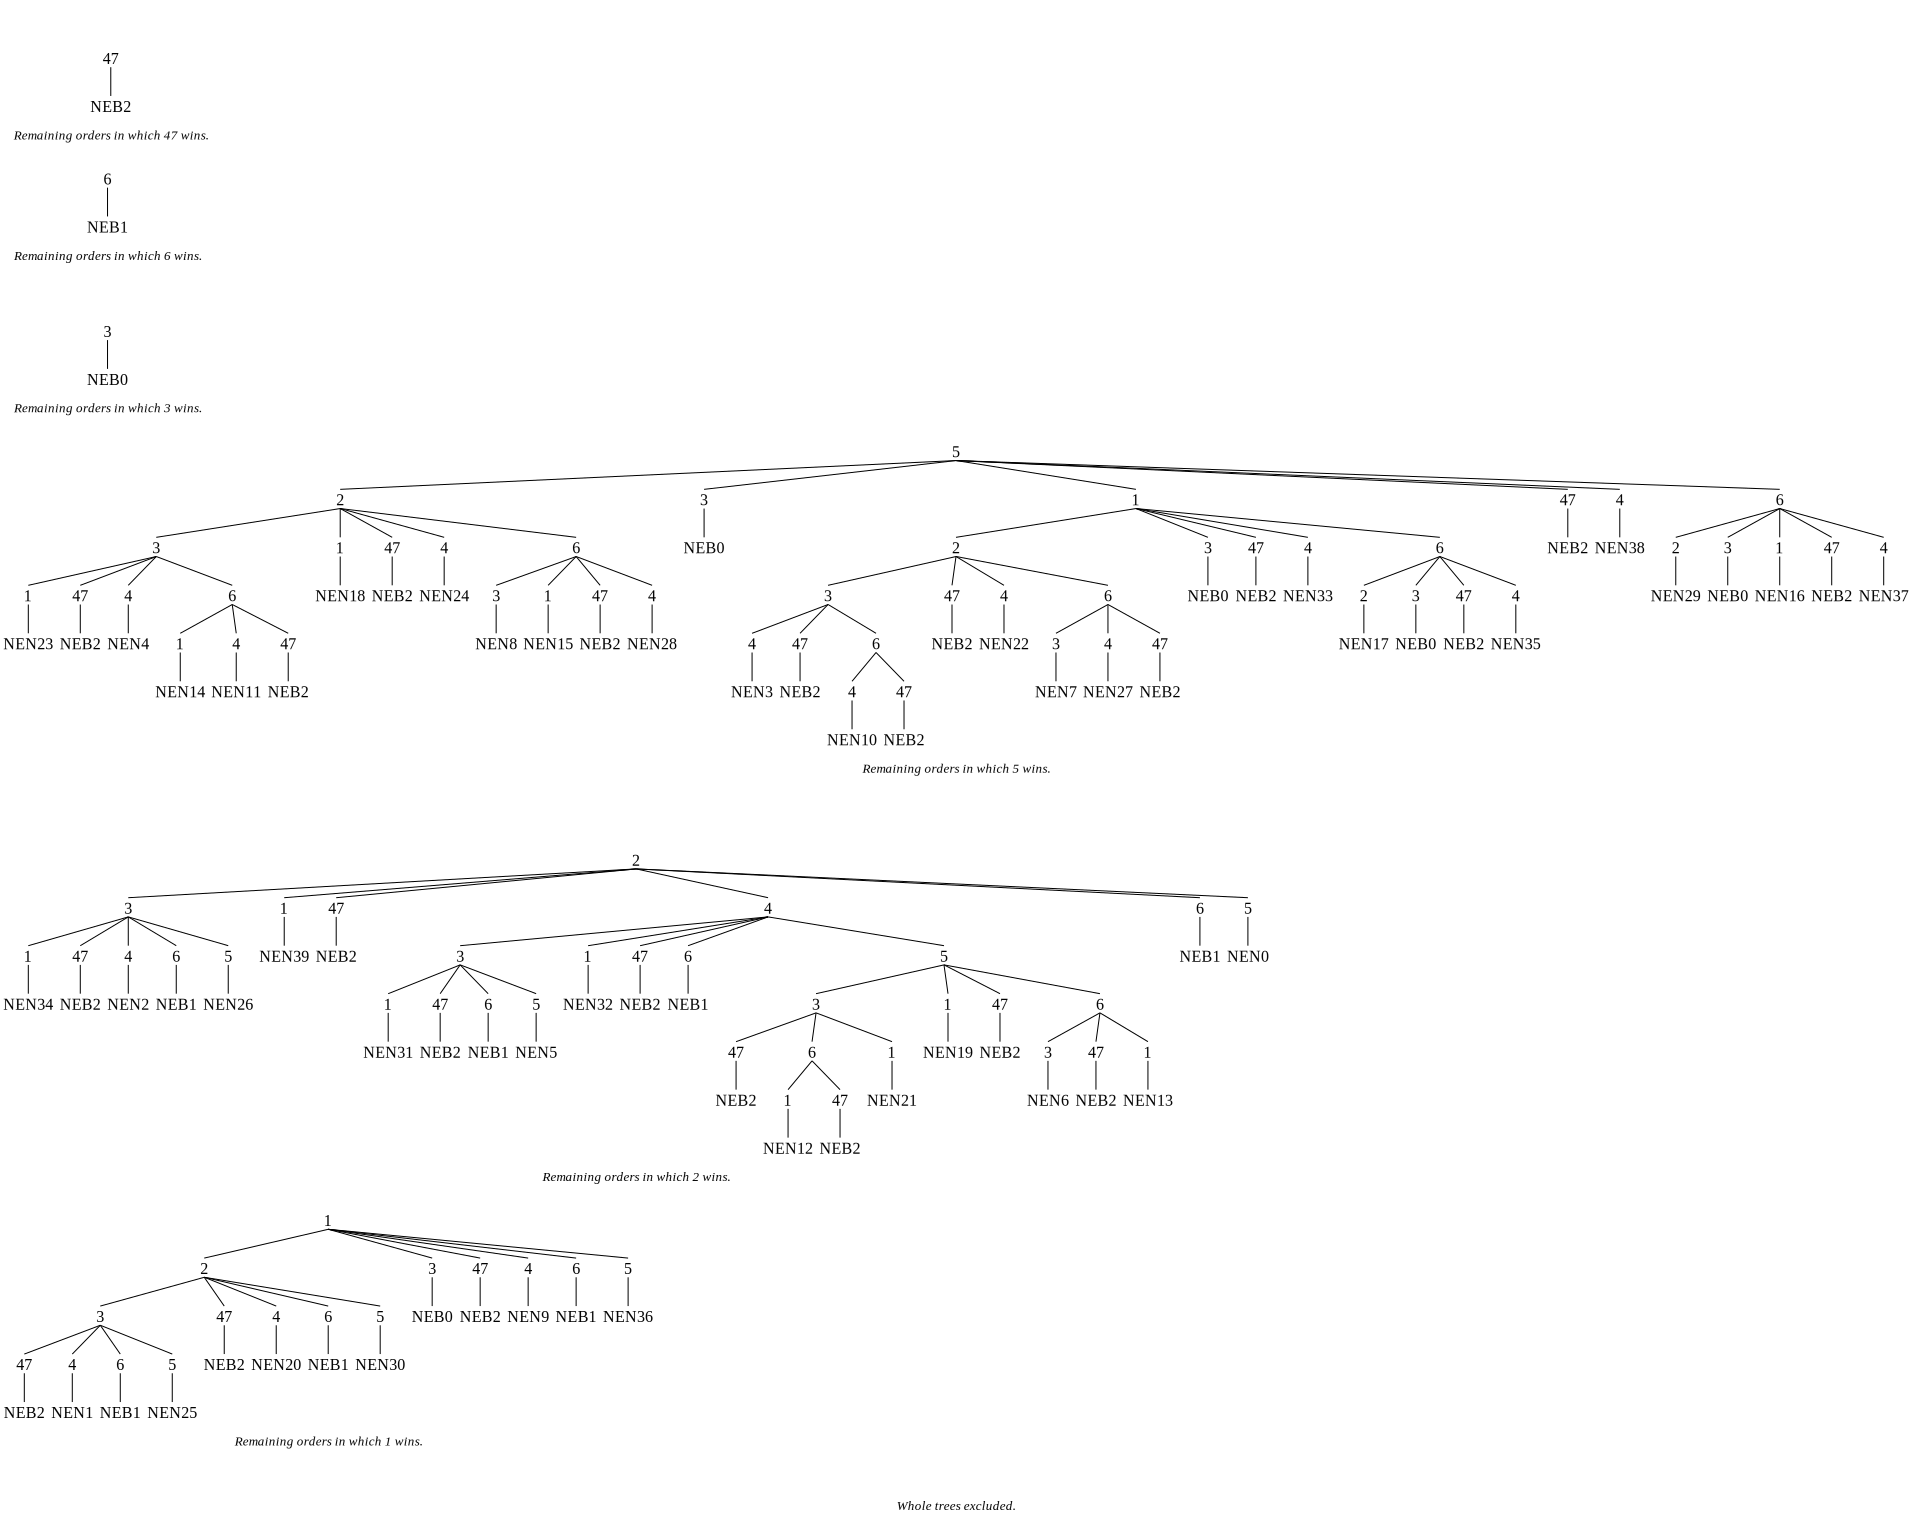

In [24]:
import json
import svgling
from svgling.figure import Caption, SideBySide, RowByRow
a_file = open("../AssertionJSON/RAIRE_sample_audit1.json")
auditfile = json.load(a_file)
apparentWinner = auditfile["Audits"][0]["Winner"]
print("Apparent winner: "+apparentWinner)
apparentNonWinners=auditfile["Audits"][0]["Eliminated"]
print("Apparently eliminated: ")
print(apparentNonWinners)
assertions = auditfile["Audits"][0]["Assertions"]
print("**********************")
WOLosers = []
IRVElims = []

# WOLosers is a set of tuples - the first element of the tuple is the loser,
# the second element is a list of all the candidates it loses wrt.
# WOLosers = list()
for a in assertions:
    if a["Winner-Only"]=="true":
        l = a["Loser"]
        w = a["Winner"]
        # if we haven't already encountered this loser, add a new element to WOLosers.
        # if we have, add a new winner to this loser's set.
        losers = [ll for ll,_ in WOLosers]
        if l not in losers:
            #if l not in [losers[0] for losers in WOLosers]
            WOLosers.append((l,set(w)))
        else:
            for losers in WOLosers:
                if l == losers[0]:
                    losers[1].add(w)
                    
    if a["Winner-Only"]=="false":
        l = a["Winner"]
        IRVElims.append((l,set(a["Already-Eliminated"])  ))
            
# print(a)
print("Not-Eliminated-Before assertions: ")
for loser in WOLosers:
    print("NEB"+str(WOLosers.index(loser))+": Candidate "+str(loser[1])+" cannot be eliminated before "+str(loser[0]))
    
print("Not-Eliminated-Next assertions: ")
for winner in IRVElims:
    print("NEN"+str(IRVElims.index(winner))+": Candidate "+str(winner[0])+
          " cannot be eliminated next when "+str(winner[1])+" are eliminated.")

print("**********************")
# return [[c, "NEN",IRVElims.index(winner)]]

    
    
# This takes a root candidate c and a set S of candidates still to
# be built in to the tree (i.e. those to be eliminated earlier, closer to the leaves)
# it checks whether c is winner-only dominated by any candidate in S and, if so,
# prunes the tree here.
def buildRemainingTreeAsLists(c,S):
    # If c is in the list of candidates yet to be eliminated, this is a bug.
    if c in S:
        print("Oops c is in S.  c = ")
        print(c)
        print(" S = ")
        print(S)
    # if S is empty, return the leaf
    # Note that this indicates an error in the RAIRE audit
    # process - we're producing a tree 
    # in which we haven't pruned all the leaves.  
    # The intention is to make it visually obvious to an auditor.
    # Hence the ***
    if not S:
        return [[c, "***Unpruned leaf - ", "this is a problem!***"]]

    # if c is a loser defeated by a candidate in S, prune here.
    # Tag with NEB assertion number we used to prune.
    for loser in WOLosers:
        if c==loser[0] and ((loser[1] & S)):
            return [[c, "NEB",WOLosers.index(loser)]]
    
    # if c cannot be eliminated by IRV in exactly the case where S is the already-eliminated set, 
    # prune here.  Tag with NEN assertion number we used to prune.
    for winner in IRVElims:
        if c==winner[0] and winner[1]==S:
            return [[c, "NEN",IRVElims.index(winner)]]

            
    tree=[c,[]]
    for c2 in S:
        smallerSet = S.copy()
        smallerSet.remove(c2)
        tree[1].append(buildRemainingTreeAsLists(c2,smallerSet))
    
    return tree
        
# Convert a tree in list form into the same tree in tuple form suitable for
# svgling.
def treeListToTuple(t):
    # If t is an empty list, we shouldn't have got this far.
    if not t:
        print("Error: empty list in tree drawing")
    # Leaf.  Return the name of the candidate and the assertion we've excluded it with.
    if len(t) == 1:     
        return((t[0][0],t[0][1]+str(t[0][2]))) 
    # Otherwise recurse.
    else:
        tList = []
        for branch in t[1]:
            tList.append(treeListToTuple(branch))
        return ((t[0],)+tuple(tList))

# Print out the results
elimTrees=[]
for c in apparentNonWinners:
    candidateSet=set(apparentNonWinners).copy()
    candidateSet.add(apparentWinner)
    candidateSet.remove(c)
    treeAsLists=buildRemainingTreeAsLists(c,candidateSet)
    treeAsTuples=treeListToTuple(treeAsLists)
    drawnTree = svgling.draw_tree(treeAsTuples)
    elimTrees.append(Caption(drawnTree,"Remaining orders in which "+c+" wins."))


print("Built "+str(len(elimTrees))+" trees.")
print("Warning: hardcoded to print 6 trees!")

Caption(RowByRow(RowByRow(RowByRow(elimTrees[0],elimTrees[1]),RowByRow(elimTrees[2],elimTrees[3])),RowByRow(elimTrees[4],elimTrees[5])   ), "Whole trees excluded.")



# RAIRE example assertions

This notebook provides a simple example of the kinds of assertions RAIRE might derive.
Suppose we have the following IRV CVRs:
- 10 votes list (Alpine, Beach, Canyon)
- 10 votes list (Alpine, Beach, Desert)
- 25 votes list (Beach)
- 6  votes list (Canyon, Alpine, Beach)
- 4  votes list (Desert, Alpine, Beach)
The apparent winner is Alpine, with apparent elimination order Desert, Canyon, Beach, (Alpine), shown below in red.
The audit needs to exclude all the other possible winners, though we don't care about other elimination orders in which Alpine wins.  To see how this works, click in each python box (including the import box above) and press shift-enter, working down the page.

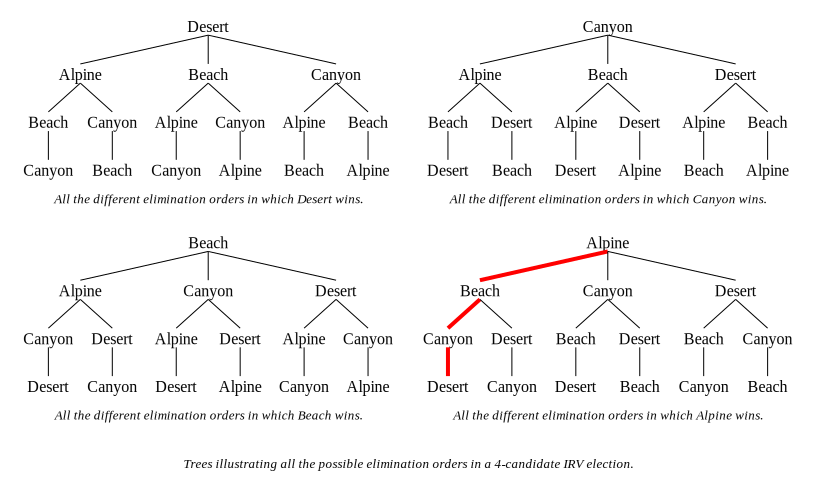

In [17]:
qrtree0 = ("Alpine", ("Beach", ("Canyon", "Desert"), ("Desert", "Canyon")),("Canyon", ("Beach", "Desert"), ("Desert", "Beach")),("Desert", ("Beach", "Canyon"), ("Canyon", "Beach")))
out0 = svgling.draw_tree(qrtree0)
out0.set_edge_style((0,), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0.set_edge_style((0,0), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0.set_edge_style((0,0,0), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0 = Caption(out0, "All the different elimination orders in which Alpine wins.")

qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),("Canyon", ("Alpine", "Desert"), ("Desert", "Alpine")),("Desert", ("Alpine", "Canyon"), ("Canyon", "Alpine")))
out1 = svgling.draw_tree(qrtree1)
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon", ("Alpine", ("Beach", "Desert"), ("Desert", "Beach")),("Beach", ("Alpine", "Desert"), ("Desert", "Alpine")),("Desert", ("Alpine", "Beach"), ("Beach", "Alpine")))
out2 = svgling.draw_tree(qrtree2)
out2 = Caption(out2, "All the different elimination orders in which Canyon wins.")

qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"), ("Canyon", "Alpine")),("Canyon", ("Alpine", "Beach"), ("Beach", "Alpine")))
out3 = svgling.draw_tree(qrtree3)
out3 = Caption(out3, "All the different elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), SideBySide(out1,out0)), "Trees illustrating all the possible elimination orders in a 4-candidate IRV election.")

From now on we disregard the tree in which Alpine wins, and try to exclude all the others.  First consider Winner-only (WO) comparison between Alpine and Canyon - WO(Canyon,Alpine).  Canyon has only 6 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Canyon.

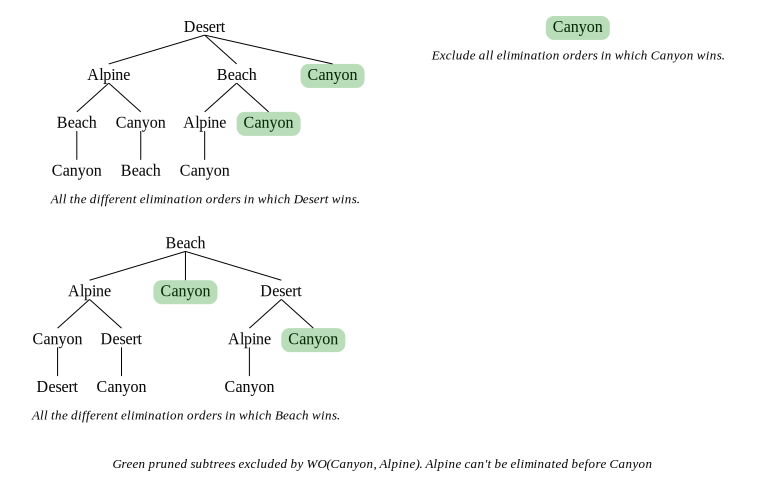

In [7]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon",("Desert", ("Alpine", "Canyon"), "Canyon"))
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,1),fill="green")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"),"Canyon"),"Canyon")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((2,),fill="green")
out3.box_constituent((1,1),fill="green")
out3 = Caption(out3, "All the different elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned subtrees excluded by WO(Canyon, Alpine).  Alpine can't be eliminated before Canyon")

Now consider Winner-only (WO) comparison between Alpine and Desert - WO(Desert,Alpine).  Desert has only 4 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Desert.

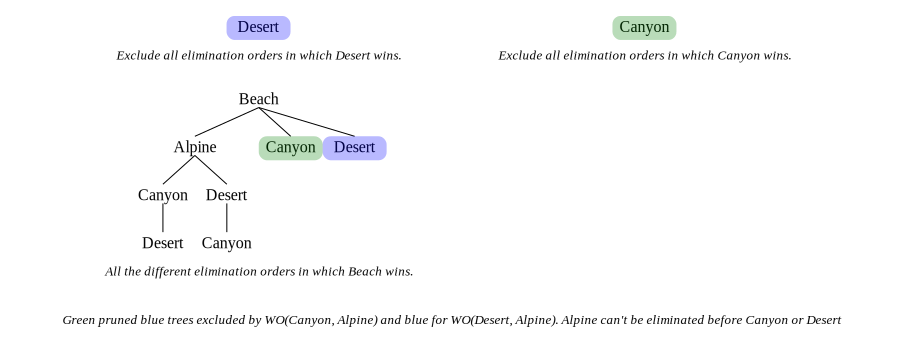

In [8]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned blue trees excluded by WO(Canyon, Alpine) and blue for WO(Desert, Alpine).  Alpine can't be eliminated before Canyon or Desert")

Finally, WO(Beach,Alpine) doesn't work, because Beach has 25 mentions.  We need to test the last IRV round and compare only Beach, Alpine. This is written as IRV(Beach, Alpine, {Alpine}).

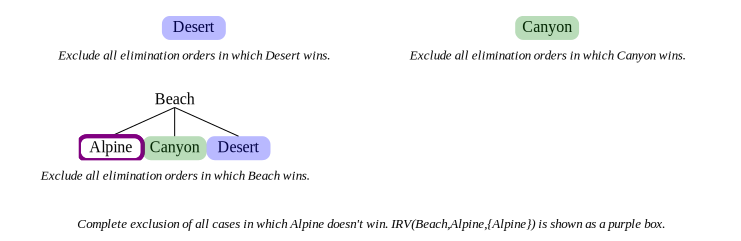

In [10]:
qrtree1 = ("Beach","Alpine","Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((0,),fill="none",stroke_width=4, stroke="purple")
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "Exclude all elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Complete exclusion of all cases in which Alpine doesn't win.  IRV(Beach,Alpine,{Alpine}) is shown as a purple box.")

Now the auditing begins!  We use Risk Limiting Audits to test all three assertions: WO(Canyon,Alpine), WO(Desert,Alpine) and IRV(Beach, Alpine, {Alpine}) simultaneously.